In [161]:
#importando librerias que se piensan utilizar
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [162]:
propiedades = pd.read_csv('properatti.csv', decimal=".")


In [163]:
#renombro columna sin nombre
propiedades.rename(columns={'Unnamed: 0':'id'}, inplace=True)

In [164]:
#Analizamos los datos del evaluador de properati y nos quedamos con los campos 
#ubicacion
#tipo de propiedad
#Ambientes
#Cantidad de baños
#superficie cubierta total
#superficie descubierta total
#cochera y amenities

In [165]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
id                            121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

In [166]:
#Nos quedamos con las columnas que nos importan 
df_prop = propiedades[["id","place_with_parent_names",
                       "place_name","property_type", 
                       "rooms",
                       "surface_total_in_m2",
                       "surface_covered_in_m2", 
                       "lat-lon",
                       "description",
                       "title",
                       "price",
                       "currency",
                       'price_per_m2',
                       "price_usd_per_m2",
                       'price_aprox_local_currency', 
                       'price_aprox_usd']]

In [167]:
# Verifico duplicados
print('DF sin duplicados:',df_prop.duplicated(subset=None, keep='first').shape)
print('DF Properatti:', df_prop[['place_with_parent_names']].shape)


DF sin duplicados: (121220,)
DF Properatti: (121220, 1)


In [168]:
#Borramos registros con valores duplicadios
df_prop_sin_d = df_prop.drop_duplicates(['place_with_parent_names', 
                          'description', 'title', 
                          'rooms',
                          'surface_total_in_m2'], keep='first')

print('DF Properatti:', df_prop_sin_d[['place_with_parent_names']].shape)

DF Properatti: (111386, 1)


In [169]:
#una vez borrados los duplicados validmos los datos nulos
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66482
surface_total_in_m2           37294
surface_covered_in_m2         18301
lat-lon                       45356
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29593
price_usd_per_m2              47941
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [170]:
df_prop_sin_d.drop([107390,50387,50388], inplace = True)

In [171]:
df_prop_sin_d['currency'].unique()

array(['USD', nan, 'ARS'], dtype=object)

In [172]:
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66479
surface_total_in_m2           37291
surface_covered_in_m2         18298
lat-lon                       45353
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29590
price_usd_per_m2              47938
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [173]:
#llenamos superficie total con superficie cubierta
df_prop_sin_d.fillna({'surface_total_in_m2' : df_prop_sin_d['surface_covered_in_m2']}, inplace = True)

In [174]:
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66479
surface_total_in_m2           11755
surface_covered_in_m2         18298
lat-lon                       45353
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29590
price_usd_per_m2              47938
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [175]:
#Rellenamos faltantes la variable price usd per m2 cuando hayan datos de precio total y superficie
# recalcular el precio usd por m2 donde este sea null
print(df_prop_sin_d["price_usd_per_m2"].isnull().sum()) # nulos antes
df_prop_sin_d["price_usd_per_m2"] = np.where(df_prop_sin_d["price_usd_per_m2"].isnull(),np.divide(df_prop_sin_d["price_aprox_usd"],df_prop_sin_d["surface_total_in_m2"]),df_prop_sin_d["price_usd_per_m2"])
print(df_prop_sin_d["price_usd_per_m2"].isnull().sum()) # nulos despues

47938
24457


C:\Users\q08296\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\q08296\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [176]:
df_prop_sin_d.loc[df_prop_sin_d['price_usd_per_m2'].isna() &
                  (~df_prop_sin_d['price_aprox_usd'].isna())&
                  (~df_prop_sin_d['surface_total_in_m2'].isna())&
                  (df_prop_sin_d['surface_total_in_m2']!=0.),'price_usd_per_m2']= df_prop_sin_d['price_aprox_usd']/df_prop_sin_d['surface_total_in_m2']

In [177]:
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66479
surface_total_in_m2           11755
surface_covered_in_m2         18298
lat-lon                       45353
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29590
price_usd_per_m2              24457
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [178]:
#df_prop_sin_d.drop(price = np.nan)
#df_prop_sin_d.drop([107390,50387,50388], inplace = True)
#df_prod_price = df_prop_sin_d.drop['price'].dropna()
df_prop_price = df_prop_sin_d.dropna(subset=['price'])
df_prop_price.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         56361
surface_total_in_m2            7267
surface_covered_in_m2         12398
lat-lon                       38225
description                       2
title                             0
price                             0
currency                          1
price_per_m2                  12400
price_usd_per_m2               7267
price_aprox_local_currency        0
price_aprox_usd                   0
dtype: int64

In [179]:
df_prop_price['place_name'].fillna( value = 'Tigre', inplace = True)

In [180]:
df_prop_price.isnull().sum()

id                                0
place_with_parent_names           0
place_name                        0
property_type                     0
rooms                         56361
surface_total_in_m2            7267
surface_covered_in_m2         12398
lat-lon                       38225
description                       2
title                             0
price                             0
currency                          1
price_per_m2                  12400
price_usd_per_m2               7267
price_aprox_local_currency        0
price_aprox_usd                   0
dtype: int64

In [181]:
# 1 - Pasamos el campo a minúscula. Propiedades es el file original o el tuyo luqitas si estas moviendo el campo with parent names 
df_temp_prop = df_prop_price['place_with_parent_names'].str.lower()


In [182]:
# 2 - Separamos para poder analizar cuantas columnas tenemos
df_temp_split = pd.DataFrame(df_temp_prop.str.split('|', expand=True))
df_temp_split.head(3)


,0,1,2,3,4,5,6
0,,argentina,capital federal,mataderos,,None,None
1,,argentina,bs.as. g.b.a. zona sur,la plata,,None,None
2,,argentina,capital federal,mataderos,,None,None


In [183]:
# 3 - Cambiamos los nombres de las columnas
df_temp_split=df_temp_split.rename(columns={1: 'Pais',2: 'Localidad/Provincia(Arg)',3:'Partido',4: 'Barrio', 5:'Barrio Cerrado'})


In [184]:
# 4 Agregamos una nueva columna Zona(CABA). ya que vimos que por ej Palermo tiene divisiones ej Palermos Soho 
df_temp_split['Zona(CABA)']=''
df_temp_split.head(2)


,0,Pais,Localidad/Provincia(Arg),Partido,Barrio,Barrio Cerrado,6,Zona(CABA)
0,,argentina,capital federal,mataderos,,None,None,
1,,argentina,bs.as. g.b.a. zona sur,la plata,,None,None,


In [185]:
# 5 Creamos varias condiciones que vamos a utilizar para formatear las columnas
cond_localidad_capital = df_temp_split['Localidad/Provincia(Arg)']=='capital federal'
cond_localidad_nocapital = df_temp_split['Localidad/Provincia(Arg)']!='capital federal'
cond_barrio_vacio = df_temp_split['Barrio']==''
cond_barrio_novacio = df_temp_split['Barrio']!=''
cond_partido_novacio = df_temp_split['Partido']!=''
cond_barrio_equal_zona = df_temp_split['Zona(CABA)']==df_temp_split['Barrio']


In [186]:
# 6 Aplicamos las reglas

# Regla 1 : es capital, tenemos y barrio y tenemos partido -> el partido es la zona : ejemplo Palermo - Palermo Soho
df_temp_split.loc[cond_localidad_capital & cond_partido_novacio & cond_barrio_novacio,'Zona(CABA)']=df_temp_split.loc[cond_localidad_capital & cond_partido_novacio & cond_barrio_novacio,'Partido']



In [187]:
# Regla 2 : es capital, no tenemos barrio y tenemos partido -> el partido es el barrio
df_temp_split.loc[cond_localidad_capital & cond_partido_novacio & cond_barrio_vacio,'Barrio']=df_temp_split.loc[cond_localidad_capital & cond_partido_novacio & cond_barrio_vacio,'Partido']


In [188]:
# Regla 3 : es capital, y tenemos partido -> lo limpiamos porque con las reglas anteriores ya nos encargamos del partido
df_temp_split.loc[cond_localidad_capital & cond_partido_novacio,'Partido']=''


In [189]:
# Regla 4 : es capital, y la zona = al barrio, limiamos la zona y dejamos solo el barrio
df_temp_split.loc[cond_localidad_capital & cond_barrio_equal_zona,'Zona(CABA)']=''




In [190]:
# Analisis mas profundo de gran buenos aires y Provincias de Argentina --> PENDIENTE

# 7 - Acomodamos las columnas 
df_temp_split = df_temp_split[['Pais','Localidad/Provincia(Arg)','Partido','Zona(CABA)','Barrio','Barrio Cerrado']]

df_temp_split.head(10)

,Pais,Localidad/Provincia(Arg),Partido,Zona(CABA),Barrio,Barrio Cerrado
0,argentina,capital federal,,,mataderos,None
1,argentina,bs.as. g.b.a. zona sur,la plata,,,None
2,argentina,capital federal,,,mataderos,None
3,argentina,capital federal,,,liniers,None
4,argentina,buenos aires costa atlántica,mar del plata,,centro,
6,argentina,bs.as. g.b.a. zona norte,vicente lópez,,munro,
7,argentina,capital federal,,,belgrano,None
8,argentina,capital federal,,,belgrano,None
9,argentina,santa fe,rosario,,,None
10,argentina,córdoba,córdoba,,,None


In [191]:


# 8 limpiamos los valores nulos
indices = pd.isnull(df_temp_split["Pais"])
df_temp_split.at[indices,"Pais"] = ''

indices = pd.isnull(df_temp_split["Zona(CABA)"])
df_temp_split.at[indices,"Zona(CABA)"] = ''

indices = pd.isnull(df_temp_split["Barrio"])
df_temp_split.at[indices,"Barrio"] = ''

indices = pd.isnull(df_temp_split["Barrio Cerrado"])
df_temp_split.at[indices,"Barrio Cerrado"] = ''

indices = pd.isnull(df_temp_split["Localidad/Provincia(Arg)"])
df_temp_split.at[indices,"Localidad/Provincia(Arg)"] = ''

display(df_temp_split.sample(10))
display(df_temp_split.sample(10))



,Pais,Localidad/Provincia(Arg),Partido,Zona(CABA),Barrio,Barrio Cerrado
44482,argentina,buenos aires costa atlántica,mar del plata,,,
113934,argentina,capital federal,,palermo,palermo viejo,
13781,argentina,bs.as. g.b.a. zona norte,pilar,,,
26783,argentina,capital federal,,,belgrano,
105620,argentina,córdoba,córdoba,,,
47442,argentina,capital federal,,,villa devoto,
108621,argentina,bs.as. g.b.a. zona sur,la plata,,city bell,
71437,argentina,córdoba,córdoba,,,
118408,argentina,buenos aires costa atlántica,mar del plata,,,
55427,argentina,capital federal,,,belgrano,


,Pais,Localidad/Provincia(Arg),Partido,Zona(CABA),Barrio,Barrio Cerrado
46458,argentina,capital federal,,,las cañitas,
55877,argentina,capital federal,,,barrio norte,
38407,argentina,buenos aires costa atlántica,mar del plata,,,
69705,argentina,bs.as. g.b.a. zona sur,lomas de zamora,,lomas de zamora,
55887,argentina,bs.as. g.b.a. zona sur,avellaneda,,wilde,
19618,argentina,bs.as. g.b.a. zona norte,vicente lópez,,olivos,
58833,argentina,capital federal,,,barracas,
109000,argentina,capital federal,,palermo,palermo hollywood,
31372,argentina,neuquén,neuquén,,,
40065,argentina,bs.as. g.b.a. zona sur,berazategui,,ranelagh,


In [192]:
# 9 - Tratamos dummies
# Condicion barrio vacio
cond_barrio_no_vacio = df_temp_split['Barrio']!=''


In [193]:
# Capital y barrio vacio
aux=pd.DataFrame(df_temp_split.loc[cond_localidad_capital & cond_barrio_no_vacio]['Barrio'])


aux.head()

,Barrio
0,mataderos
2,mataderos
3,liniers
7,belgrano
8,belgrano


In [194]:
# la convertimos en dummies
col_dummies = pd.get_dummies(aux, prefix=['Barrio'])


In [195]:
# 10 concateamos con tu file lukitas. El que venias manejando hasta aca. Donde borramos con carrasca el sabado

final=pd.concat([df_prop_price,col_dummies], axis='columns')

#11 descartamos  lo que no tenga barrio
aux=final.loc[cond_localidad_capital & cond_barrio_no_vacio]

###aux -> archivo final



In [196]:
aux.head()

,id,place_with_parent_names,place_name,property_type,rooms,surface_total_in_m2,surface_covered_in_m2,lat-lon,description,title,...,Barrio_villa general mitre,Barrio_villa lugano,Barrio_villa luro,Barrio_villa ortuzar,Barrio_villa pueyrredón,Barrio_villa real,Barrio_villa riachuelo,Barrio_villa santa rita,Barrio_villa soldati,Barrio_villa urquiza
0,0,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,NaN,55.0,40.0,"-34.6618237,-58.5088387","2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,|Argentina|Capital Federal|Mataderos|,Mataderos,apartment,NaN,55.0,55.0,"-34.6522615,-58.5229825",2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,|Argentina|Capital Federal|Liniers|,Liniers,PH,NaN,NaN,NaN,"-34.6477969,-58.5164244",PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,45.0,40.0,"-34.5598729,-58.443362",EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,65.0,60.0,"-34.5598729,-58.443362",EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
aux.isnull().sum()

id                                 0
place_with_parent_names            0
place_name                         0
property_type                      0
rooms                          11814
surface_total_in_m2              508
surface_covered_in_m2           1484
lat-lon                         5100
description                        0
title                              0
price                              0
currency                           0
price_per_m2                    1486
price_usd_per_m2                 508
price_aprox_local_currency         0
price_aprox_usd                    0
Barrio_abasto                      0
Barrio_agronomía                   0
Barrio_almagro                     0
Barrio_balvanera                   0
Barrio_barracas                    0
Barrio_barrio norte                0
Barrio_belgrano                    0
Barrio_boca                        0
Barrio_boedo                       0
Barrio_caballito                   0
Barrio_catalinas                   0
B

In [198]:
#### ojo no borrar x que lo arreglamos despues
#df_final = aux.dropna(subset=['rooms'])

In [199]:
#df_final.isnull().sum()
df_final = aux.dropna(subset=['surface_covered_in_m2'])
#df_final = aux.dropna(subset=['rooms'])

#df.drop('column_name', axis=1, inplace=True)


In [200]:
df_final.drop('lat-lon', axis=1, inplace=True)
df_final.drop('price', axis=1, inplace=True)
#df_final.drop('surface_covered_in_m2', axis=1, inplace=True)

In [201]:
df_final = df_final.dropna(subset=['surface_covered_in_m2'])
df_final.isnull().sum()

id                                 0
place_with_parent_names            0
place_name                         0
property_type                      0
rooms                          10665
surface_total_in_m2                0
surface_covered_in_m2              0
description                        0
title                              0
currency                           0
price_per_m2                       2
price_usd_per_m2                   0
price_aprox_local_currency         0
price_aprox_usd                    0
Barrio_abasto                      0
Barrio_agronomía                   0
Barrio_almagro                     0
Barrio_balvanera                   0
Barrio_barracas                    0
Barrio_barrio norte                0
Barrio_belgrano                    0
Barrio_boca                        0
Barrio_boedo                       0
Barrio_caballito                   0
Barrio_catalinas                   0
Barrio_centro / microcentro        0
Barrio_chacarita                   0
B

In [202]:
df_final.head(10)

,id,place_with_parent_names,place_name,property_type,rooms,surface_total_in_m2,surface_covered_in_m2,description,title,currency,...,Barrio_villa general mitre,Barrio_villa lugano,Barrio_villa luro,Barrio_villa ortuzar,Barrio_villa pueyrredón,Barrio_villa real,Barrio_villa riachuelo,Barrio_villa santa rita,Barrio_villa soldati,Barrio_villa urquiza
0,0,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,NaN,55.0,40.0,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,|Argentina|Capital Federal|Mataderos|,Mataderos,apartment,NaN,55.0,55.0,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,45.0,40.0,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,65.0,60.0,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,13,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,50.0,30.0,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,14,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,42.0,31.0,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,16,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,4.0,140.0,98.0,Ventas Mataderos al frente Duplex 4 amb.- Plan...,VENTA-MATADEROS-DUPLEX 4 AMB.,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,19,|Argentina|Capital Federal|Palermo|,Palermo,apartment,3.0,104.0,96.0,Excelente semipiso al contra frente en Bulnes ...,"Bulnes y Libertador: espectacular pulmón, con ...",USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,21,|Argentina|Capital Federal|Palermo|,Palermo,apartment,4.0,118.0,73.0,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",Departamento de 4 ambientes en Venta en Palermo,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,29,|Argentina|Capital Federal|Flores|,Flores,apartment,2.0,43.0,43.0,Departamento muy luminoso con todos sus ambien...,Departamento en venta floresta,USD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#NICO BEGIN : AMENITIES NRO AMBIENTES Y TIPO PROPIEDAD

In [203]:
#Me quedo con la columna description y titulo
dfDescripcion = pd.DataFrame(df_final['description'].str.lower())
dfTitle = pd.DataFrame(df_final['title'].str.lower())
df_id = pd.DataFrame(df_final['id'])

In [204]:
#Creamos un diccionario 
dic = {
  'uno': '1',
  'dos': '2',
  'tres': '3',
  'cuatro': '4',
  'cinco': '5',
  'seis': '6',
  'siete': '7',
  'ocho': '8',
  'nueve': '9',
  'diez': '10',
  '1er': "1",
  '2do': "2",
  '3er': "3",
  '4to': "4",
  'º':"",
  'exp=': "expensas ",
  'abl=': " abl",
  'monoh':' monoambiente ',
  'monoambiente':'1 ambiente',
  'depto':' departamento ',
  'dorm':' dormitorios ',
  ' amb ':' ambientes ',
   'amb.':' ambientes ',
  'ambiente':' ambientes ',
  'ambientess':' ambientes ',
    'dormitorioss':' dormitorios ',
  'dormitorio':' dormitorios ',
  'habitacion':' dormitorios ',
  'habitaciones':' dormitorios ',
  'baa  o':' banos ',
  'usd':' u$d ',
  'u$s':' u$d ',
  'garage':' cochera ',
  'garaje':' cochera ', 
  'laundry':' lavadero ',
  'piscina':' pileta ',
  'swit':' suite ',
  'dormitorios suite':' dormitorios en suite ',
  'pre-venta':' emprendimiento ',
  'desde el pozo':' emprendimiento',
  'venta en pozo':' emprendimiento',
  'construccin':' construccion',
  'proyecto en construccion':'emprendimiento',
  'financiado':'emprendimiento',
  'cuota':'emprendimiento',
  'exp': ' expensas',
  'expensa':  'expensas',
  'posibilidad de cochera':  '',
  'baul': 'baulera'
}

In [205]:
#aplicamos diccionario sobre la columna descripcion
for key, valor in dic.items():
    dfDescripcion.replace(key, valor, regex=True, inplace=True)
#aplicamos diccionario sobre la columna descripcion
for key, valor in dic.items():
    dfTitle.replace(key, valor, regex=True, inplace=True)
dfResult = dfDescripcion.join(dfTitle)
dfResult = dfResult.join(df_id)

In [206]:
#Agrego columna dummy si tiene pileta
patron = r'(pileta|pisci)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["pileta"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy si amenities
patron = r'(ameni|gimn|gym|lavadero|sum|usos mult|solarium)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["amenities"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy si tiene garage
patron = r'(garage|cocher|cochera)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["cochera"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si tiene garage
patron = r'(pozo|cuota|proyec|emprendim)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["pozo_en_descrip"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si tiene garage
patron = r'(pozo|cuota|proyec|emprendim)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["pozo_en_title"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si es a estrenar
patron = r'(a est|estren|a estrenar|estrenar)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["a_estrenar"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si es a estrenar
patron = r'(expensas|expensas)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["expensas"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si tiene baulera
patron = r'(baulera|baul)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["baulera"] = 1 * dfResult.description.apply(lambda x: bool(regex.search(str(x))))
#Agrego columna dummy para saber si es apto credito
patron = r'(apto credito|aptocredito)'
regex = re.compile(patron, flags=re.IGNORECASE)
dfResult["apto_credito"] = 1 * dfResult.title.apply(lambda x: bool(regex.search(str(x)))) 
dfResult.head()

,description,title,id,pileta,amenities,cochera,pozo_en_descrip,pozo_en_title,a_estrenar,expensas,baulera,apto_credito
0,2 ambientes s entes tipo casa planta baja po...,2 ambientes s entes tipo casa sin expensass...,0,0,1,0,0,0,0,0,0,0
2,2 ambientes s entes 3 piso lateral living co...,2 ambientes s entes 3 piso con ascensor apto...,2,0,1,0,0,0,0,1,0,1
7,excelente 1 ambientes s ente a estrenar ampl...,jose hernandez 1400 1 ambientes s ente estr...,7,1,1,0,0,0,1,0,0,0
8,excelente 2 ambientes s entes estrenar ampl...,jose hernandez 1400 2 ambientes s entes es...,8,1,1,0,0,0,1,0,0,0
13,torre i mondrian. 3 ambientes s entes con t...,vitraux palermo,13,1,1,0,1,1,0,1,0,0


In [207]:
amenities_dummy=dfResult.iloc[:,2:]
amenities_dummy.head()

,id,pileta,amenities,cochera,pozo_en_descrip,pozo_en_title,a_estrenar,expensas,baulera,apto_credito
0,0,0,1,0,0,0,0,0,0,0
2,2,0,1,0,0,0,0,1,0,1
7,7,1,1,0,0,0,1,0,0,0
8,8,1,1,0,0,0,1,0,0,0
13,13,1,1,0,1,1,0,1,0,0


In [208]:
#arrancamos con las habitaciones y el tipo de propiedad

In [209]:
df_final.rename(columns={'property_type':'Tipo_propiedad','rooms':'Ambientes','description':'Descripción','title':'Título'},inplace=True)
df_amb=df_final[['Tipo_propiedad','Ambientes','Título','Descripción']]  
df_amb.head()

,Tipo_propiedad,Ambientes,Título,Descripción
0,PH,NaN,2 AMB TIPO CASA SIN EXPENSAS EN PB,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,..."
2,apartment,NaN,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...
7,apartment,NaN,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...
8,apartment,NaN,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...
13,apartment,1.0,Vitraux Palermo,Torre I Mondrian. 3 ambientes con terraza y d...


In [210]:
df_temp = df_amb["Título"].str.extract("(\d+)\s?AMB+",expand=True)
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Título"].str.extract("(\d+)\s?amb+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Título"].str.extract("(\d+)\s?dorm+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Título"].str.extract("(\d+)\s?DORM+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Descripción"].str.extract("(\d+)\s?AMB+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Descripción"].str.extract("(\d+)\s?amb+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Descripción"].str.extract("(\d+)\s?dorm+",expand=True))
print(df_temp.isnull().sum())

df_temp = df_temp.fillna(df_amb["Descripción"].str.extract("(\d+)\s?DORM+",expand=True))
print(df_temp.isnull().sum())

df_temp=df_temp.astype('float64')
df_temp.head()

0    21138
dtype: int64
0    16862
dtype: int64
0    16532
dtype: int64
0    16470
dtype: int64
0    13485
dtype: int64
0    9696
dtype: int64
0    8735
dtype: int64
0    8536
dtype: int64


,0
0,2.0
2,2.0
7,NaN
8,NaN
13,3.0


In [211]:
df_temp.rename(columns={0:'Ambientes corregido'},inplace=True)
df_temp.head() 

,Ambientes corregido
0,2.0
2,2.0
7,NaN
8,NaN
13,3.0


In [212]:
#### ojo nuevo

df_temp =pd.concat([df_amb,df_temp], axis='columns')


 
 

In [213]:
df_temp[['Ambientes','Ambientes corregido']].head(30)

,Ambientes,Ambientes corregido
0,NaN,2.0
2,NaN,2.0
7,NaN,NaN
8,NaN,NaN
13,1.0,3.0
14,1.0,NaN
16,4.0,4.0
19,3.0,NaN
21,4.0,4.0
29,2.0,NaN


In [214]:
df_temp['Amb']=np.where(df_temp["Ambientes"].isnull(),
                                          df_temp['Ambientes corregido'],
                                          df_temp["Ambientes"])

In [215]:
df_temp=df_temp[['Amb']]
df_temp.head(20)

,Amb
0,2.0
2,2.0
7,NaN
8,NaN
13,1.0
14,1.0
16,4.0
19,3.0
21,4.0
29,2.0


In [216]:
#arranco con el tipo de propiedad

In [217]:
df_tipo=df_final[['Tipo_propiedad']]
df_tipo.head()

,Tipo_propiedad
0,PH
2,apartment
7,apartment
8,apartment
13,apartment


In [218]:
tipo_dummies = pd.get_dummies(df_tipo,prefix=['Tipo_propiedad'])
# chequeo de dummies 
tipo_dummies.head()

,Tipo_propiedad_PH,Tipo_propiedad_apartment,Tipo_propiedad_house,Tipo_propiedad_store
0,1,0,0,0
2,0,1,0,0
7,0,1,0,0
8,0,1,0,0
13,0,1,0,0


In [219]:
print(df_final.head())
print(tipo_dummies.head())
print(df_temp.head())
print(amenities_dummy.head())

    id                           place_with_parent_names    place_name  \
0    0             |Argentina|Capital Federal|Mataderos|     Mataderos   
2    2             |Argentina|Capital Federal|Mataderos|     Mataderos   
7    7              |Argentina|Capital Federal|Belgrano|      Belgrano   
8    8              |Argentina|Capital Federal|Belgrano|      Belgrano   
13  13  |Argentina|Capital Federal|Palermo|Palermo Soho|  Palermo Soho   

   Tipo_propiedad  Ambientes  surface_total_in_m2  surface_covered_in_m2  \
0              PH        NaN                 55.0                   40.0   
2       apartment        NaN                 55.0                   55.0   
7       apartment        NaN                 45.0                   40.0   
8       apartment        NaN                 65.0                   60.0   
13      apartment        1.0                 50.0                   30.0   

                                          Descripción  \
0   2 AMBIENTES TIPO CASA PLANTA BAJA POR

In [220]:
type(amenities_dummy)

pandas.core.frame.DataFrame

In [221]:
df_prop_amb_amenities=pd.concat([tipo_dummies,df_temp,amenities_dummy], axis='columns')
df_prop_amb_amenities.head(20)

,Tipo_propiedad_PH,Tipo_propiedad_apartment,Tipo_propiedad_house,Tipo_propiedad_store,Amb,id,pileta,amenities,cochera,pozo_en_descrip,pozo_en_title,a_estrenar,expensas,baulera,apto_credito
0,1,0,0,0,2.0,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,2.0,2,0,1,0,0,0,0,1,0,1
7,0,1,0,0,NaN,7,1,1,0,0,0,1,0,0,0
8,0,1,0,0,NaN,8,1,1,0,0,0,1,0,0,0
13,0,1,0,0,1.0,13,1,1,0,1,1,0,1,0,0
14,0,1,0,0,1.0,14,1,1,0,1,1,0,1,0,0
16,1,0,0,0,4.0,16,0,0,0,0,0,0,0,0,0
19,0,1,0,0,3.0,19,0,0,0,0,0,0,0,1,0
21,0,1,0,0,4.0,21,0,0,0,0,0,0,0,0,0
29,0,1,0,0,2.0,29,0,0,0,0,0,0,0,0,0


In [222]:
df_prop_amb_amenities['Amb'].head(50)

0      2.0
2      2.0
7      NaN
8      NaN
13     1.0
14     1.0
16     4.0
19     3.0
21     4.0
29     2.0
35     4.0
38     3.0
47     NaN
48     5.0
51     6.0
52     3.0
53     2.0
54     3.0
57     NaN
59     3.0
60     2.0
98     2.0
120    3.0
137    6.0
141    3.0
157    4.0
166    2.0
167    NaN
178    1.0
187    5.0
200    7.0
203    2.0
204    NaN
207    1.0
208    1.0
209    2.0
210    2.0
215    NaN
216    4.0
218    1.0
219    6.0
220    2.0
222    3.0
225    2.0
226    1.0
227    5.0
229    1.0
230    5.0
231    4.0
241    1.0
Name: Amb, dtype: float64

In [223]:
df_final=pd.concat([df_final,df_prop_amb_amenities], axis='columns')

In [224]:
df_final[['Ambientes','Amb']].head(100)

,Ambientes,Amb
0,NaN,2.0
2,NaN,2.0
7,NaN,NaN
8,NaN,NaN
13,1.0,1.0
14,1.0,1.0
16,4.0,4.0
19,3.0,3.0
21,4.0,4.0
29,2.0,2.0


In [225]:
df_final.head(10)

,id,place_with_parent_names,place_name,Tipo_propiedad,Ambientes,surface_total_in_m2,surface_covered_in_m2,Descripción,Título,currency,...,id,pileta,amenities,cochera,pozo_en_descrip,pozo_en_title,a_estrenar,expensas,baulera,apto_credito
0,0,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,NaN,55.0,40.0,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,USD,...,0,0,1,0,0,0,0,0,0,0
2,2,|Argentina|Capital Federal|Mataderos|,Mataderos,apartment,NaN,55.0,55.0,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,USD,...,2,0,1,0,0,0,0,1,0,1
7,7,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,45.0,40.0,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,USD,...,7,1,1,0,0,0,1,0,0,0
8,8,|Argentina|Capital Federal|Belgrano|,Belgrano,apartment,NaN,65.0,60.0,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",USD,...,8,1,1,0,0,0,1,0,0,0
13,13,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,50.0,30.0,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,USD,...,13,1,1,0,1,1,0,1,0,0
14,14,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,42.0,31.0,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,USD,...,14,1,1,0,1,1,0,1,0,0
16,16,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,4.0,140.0,98.0,Ventas Mataderos al frente Duplex 4 amb.- Plan...,VENTA-MATADEROS-DUPLEX 4 AMB.,USD,...,16,0,0,0,0,0,0,0,0,0
19,19,|Argentina|Capital Federal|Palermo|,Palermo,apartment,3.0,104.0,96.0,Excelente semipiso al contra frente en Bulnes ...,"Bulnes y Libertador: espectacular pulmón, con ...",USD,...,19,0,0,0,0,0,0,0,1,0
21,21,|Argentina|Capital Federal|Palermo|,Palermo,apartment,4.0,118.0,73.0,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",Departamento de 4 ambientes en Venta en Palermo,USD,...,21,0,0,0,0,0,0,0,0,0
29,29,|Argentina|Capital Federal|Flores|,Flores,apartment,2.0,43.0,43.0,Departamento muy luminoso con todos sus ambien...,Departamento en venta floresta,USD,...,29,0,0,0,0,0,0,0,0,0


In [226]:
df_final.isnull().sum()

id                                 0
place_with_parent_names            0
place_name                         0
Tipo_propiedad                     0
Ambientes                      10665
surface_total_in_m2                0
surface_covered_in_m2              0
Descripción                        0
Título                             0
currency                           0
price_per_m2                       2
price_usd_per_m2                   0
price_aprox_local_currency         0
price_aprox_usd                    0
Barrio_abasto                      0
Barrio_agronomía                   0
Barrio_almagro                     0
Barrio_balvanera                   0
Barrio_barracas                    0
Barrio_barrio norte                0
Barrio_belgrano                    0
Barrio_boca                        0
Barrio_boedo                       0
Barrio_caballito                   0
Barrio_catalinas                   0
Barrio_centro / microcentro        0
Barrio_chacarita                   0
B

In [227]:
df_final = df_final.dropna(subset=['Ambientes'])


In [228]:
df_final.head(10)

,id,place_with_parent_names,place_name,Tipo_propiedad,Ambientes,surface_total_in_m2,surface_covered_in_m2,Descripción,Título,currency,...,id,pileta,amenities,cochera,pozo_en_descrip,pozo_en_title,a_estrenar,expensas,baulera,apto_credito
13,13,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,50.0,30.0,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,USD,...,13,1,1,0,1,1,0,1,0,0
14,14,|Argentina|Capital Federal|Palermo|Palermo Soho|,Palermo Soho,apartment,1.0,42.0,31.0,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,USD,...,14,1,1,0,1,1,0,1,0,0
16,16,|Argentina|Capital Federal|Mataderos|,Mataderos,PH,4.0,140.0,98.0,Ventas Mataderos al frente Duplex 4 amb.- Plan...,VENTA-MATADEROS-DUPLEX 4 AMB.,USD,...,16,0,0,0,0,0,0,0,0,0
19,19,|Argentina|Capital Federal|Palermo|,Palermo,apartment,3.0,104.0,96.0,Excelente semipiso al contra frente en Bulnes ...,"Bulnes y Libertador: espectacular pulmón, con ...",USD,...,19,0,0,0,0,0,0,0,1,0
21,21,|Argentina|Capital Federal|Palermo|,Palermo,apartment,4.0,118.0,73.0,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",Departamento de 4 ambientes en Venta en Palermo,USD,...,21,0,0,0,0,0,0,0,0,0
29,29,|Argentina|Capital Federal|Flores|,Flores,apartment,2.0,43.0,43.0,Departamento muy luminoso con todos sus ambien...,Departamento en venta floresta,USD,...,29,0,0,0,0,0,0,0,0,0
35,35,|Argentina|Capital Federal|Boedo|,Boedo,apartment,4.0,80.0,77.0,"Hermoso departamento de cuatro ambientes, refa...",Hermoso departamento de 4 ambientes refacciona...,USD,...,35,0,0,0,0,0,0,1,0,0
38,38,|Argentina|Capital Federal|Las Cañitas|,Las Cañitas,apartment,3.0,220.0,130.0,"Espectacular loft de exclusivo diseño, 210 ms,...","Venta depto,loft, Cañitas,210 ms,pileta propia...",USD,...,38,1,1,1,0,0,0,0,1,0
48,48,|Argentina|Capital Federal|Balvanera|,Balvanera,apartment,5.0,141.0,124.0,"PISO 13, Orientación norte, disposición al fre...",DEPARTAMENTO EN VENTA,USD,...,48,0,0,1,0,0,0,0,1,0
52,52,|Argentina|Capital Federal|Caballito|,Caballito,apartment,3.0,50.0,50.0,Departamento de 3 Ambientes al Contrafrente. S...,CABALLITO 3 AMB. EN VENTA Listo para escriturar,USD,...,52,0,1,0,0,0,1,1,1,0


In [229]:
df_final.iloc[0,1:19]


place_with_parent_names        |Argentina|Capital Federal|Palermo|Palermo Soho|
place_name                                                         Palermo Soho
Tipo_propiedad                                                        apartment
Ambientes                                                                     1
surface_total_in_m2                                                          50
surface_covered_in_m2                                                        30
Descripción                    Torre I Mondrian. 3 ambientes con terraza y d...
Título                                                          Vitraux Palermo
currency                                                                    USD
price_per_m2                                                            3723.33
price_usd_per_m2                                                           2234
price_aprox_local_currency                                          1.97089e+06
price_aprox_usd                         

In [230]:
df_final.iloc[0,20:]

Barrio_belgrano                 0
Barrio_boca                     0
Barrio_boedo                    0
Barrio_caballito                0
Barrio_catalinas                0
Barrio_centro / microcentro     0
Barrio_chacarita                0
Barrio_coghlan                  0
Barrio_colegiales               0
Barrio_congreso                 0
Barrio_constitución             0
Barrio_flores                   0
Barrio_floresta                 0
Barrio_las cañitas              0
Barrio_liniers                  0
Barrio_mataderos                0
Barrio_monserrat                0
Barrio_monte castro             0
Barrio_nuñez                    0
Barrio_once                     0
Barrio_palermo                  0
Barrio_palermo chico            0
Barrio_palermo hollywood        0
Barrio_palermo soho             1
Barrio_palermo viejo            0
Barrio_parque avellaneda        0
Barrio_parque centenario        0
Barrio_parque chacabuco         0
Barrio_parque chas              0
Barrio_parque 

#NICO END : AMENITIES NRO AMBIENTES Y TIPO PROPIEDAD

In [231]:
df_final.isnull().sum()

id                             0
place_with_parent_names        0
place_name                     0
Tipo_propiedad                 0
Ambientes                      0
surface_total_in_m2            0
surface_covered_in_m2          0
Descripción                    0
Título                         0
currency                       0
price_per_m2                   0
price_usd_per_m2               0
price_aprox_local_currency     0
price_aprox_usd                0
Barrio_abasto                  0
Barrio_agronomía               0
Barrio_almagro                 0
Barrio_balvanera               0
Barrio_barracas                0
Barrio_barrio norte            0
Barrio_belgrano                0
Barrio_boca                    0
Barrio_boedo                   0
Barrio_caballito               0
Barrio_catalinas               0
Barrio_centro / microcentro    0
Barrio_chacarita               0
Barrio_coghlan                 0
Barrio_colegiales              0
Barrio_congreso                0
          

In [232]:
#df_final.head(10)
#df_final = df_final.drop(['id'], axis=1)


In [233]:
df_final.isnull().sum()

id                             0
place_with_parent_names        0
place_name                     0
Tipo_propiedad                 0
Ambientes                      0
surface_total_in_m2            0
surface_covered_in_m2          0
Descripción                    0
Título                         0
currency                       0
price_per_m2                   0
price_usd_per_m2               0
price_aprox_local_currency     0
price_aprox_usd                0
Barrio_abasto                  0
Barrio_agronomía               0
Barrio_almagro                 0
Barrio_balvanera               0
Barrio_barracas                0
Barrio_barrio norte            0
Barrio_belgrano                0
Barrio_boca                    0
Barrio_boedo                   0
Barrio_caballito               0
Barrio_catalinas               0
Barrio_centro / microcentro    0
Barrio_chacarita               0
Barrio_coghlan                 0
Barrio_colegiales              0
Barrio_congreso                0
          

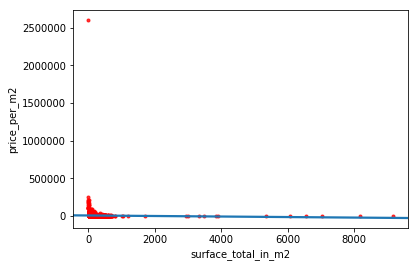

In [234]:
#Indentificamos que habia outliers que afectaban la prediccion
sns.regplot( df_final.surface_total_in_m2 ,df_final.price_per_m2 , order=1, ci=None,\
                                scatter_kws={'color':'r', 's':9})

In [235]:
#Borramos los outliers
df_final2 = df_final[(df_final.currency != 'ARS') & (df_final.Amb < 9)  & (df_final.price_per_m2 < 8000) & 
                    (df_final.surface_total_in_m2  < 500)]

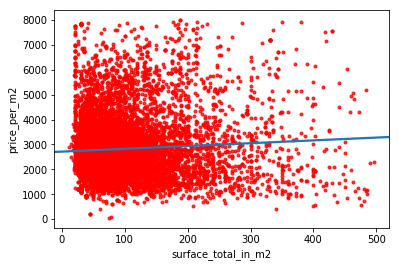

In [236]:
sns.regplot( df_final2.surface_total_in_m2 ,df_final2.price_per_m2 , order=1, ci=None,\
                                scatter_kws={'color':'r', 's':9})


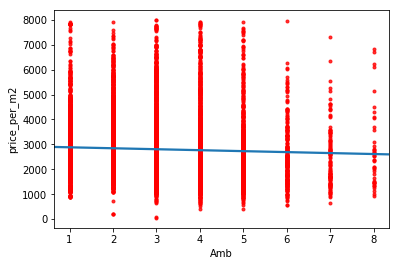

In [237]:
sns.regplot(  df_final2.Amb , df_final2.price_per_m2 , order=1, ci=None,\
                                scatter_kws={'color':'r', 's':9})

In [238]:
del df_final2['Tipo_propiedad_store'] 

In [239]:
df_final2.columns

Index(['id', 'place_with_parent_names', 'place_name', 'Tipo_propiedad',
       'Ambientes', 'surface_total_in_m2', 'surface_covered_in_m2',
       'Descripción', 'Título', 'currency', 'price_per_m2', 'price_usd_per_m2',
       'price_aprox_local_currency', 'price_aprox_usd', 'Barrio_abasto',
       'Barrio_agronomía', 'Barrio_almagro', 'Barrio_balvanera',
       'Barrio_barracas', 'Barrio_barrio norte', 'Barrio_belgrano',
       'Barrio_boca', 'Barrio_boedo', 'Barrio_caballito', 'Barrio_catalinas',
       'Barrio_centro / microcentro', 'Barrio_chacarita', 'Barrio_coghlan',
       'Barrio_colegiales', 'Barrio_congreso', 'Barrio_constitución',
       'Barrio_flores', 'Barrio_floresta', 'Barrio_las cañitas',
       'Barrio_liniers', 'Barrio_mataderos', 'Barrio_monserrat',
       'Barrio_monte castro', 'Barrio_nuñez', 'Barrio_once', 'Barrio_palermo',
       'Barrio_palermo chico', 'Barrio_palermo hollywood',
       'Barrio_palermo soho', 'Barrio_palermo viejo',
       'Barrio_parque avella

In [250]:
df_final2=df_final2.iloc[0:,1:]

In [251]:
#Guardamos el final
df_final2.to_dense().to_csv("propiedades_limpio.csv", index = False, sep=',', encoding='utf-8')